# Video Activity Recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/VAR')

In [3]:
!pip install sk-video

In [4]:
import os
import numpy as np
from model_utils import Videos_Processing
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.callbacks import ModelCheckpoint

In [5]:
# loading the dataset
data = load_files('./Dataset')
videos = data['filenames']
labels = data['target']
# 60% training data, 20% validation data, 20% testing data
train_videos, test_videos, train_labels, test_labels = train_test_split(videos, labels, test_size = 0.4, random_state = 1)
mid = len(test_videos) // 2
valid_videos = test_videos[: mid]
valid_labels = test_labels[: mid]
test_videos = test_videos[mid : ]
test_labels = test_labels[mid :]

In [6]:
print('Total number videos in the dataset', len(videos))

Total number videos in the dataset 598


In [7]:
for val, label in enumerate(data['target_names']):
    print(val, label)

0 boxing
1 handclapping
2 handwaving
3 jogging
4 running
5 walking


In [8]:
sample_video = train_videos[:1]
reader = Videos_Processing(target_size = None, to_gray = False)
sample = reader.read_videos(sample_video)
print(sample.shape)
# (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)

100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

(1, 384, 120, 160, 3)


In [9]:
print(sample_video)

['./Dataset/handclapping/person19_handclapping_d4_uncomp.avi']


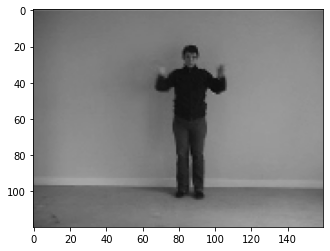

In [11]:
# 10th frame of sample video
plt.imshow(sample[0][10])

# Preprocessing the Data
Videos in dataset - 25fps frame rate, but human body doesn't make much movement in 1 sec. So, we are extracting only 5 frames per second --- required_fps

Here we are considering only first 40 frames from the videos --- max_frames, extract_frames



In [13]:
reader = Videos_Processing(target_size = (128, 128), to_gray = True, 
                max_frames = 40, extract_frames = 'first', 
                required_fps = 5, normalize_pixels = (-1, 1))

Labels are encoded using One-hot Encoding

In [14]:
X_train = reader.read_videos(train_videos)
y_train = to_categorical(train_labels, num_classes = 6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

100%|██████████| 358/358 [02:56<00:00,  2.03it/s]


Shape of training data: (358, 40, 128, 128, 1)
Shape of training labels: (358, 6)


In [15]:
X_valid = reader.read_videos(valid_videos)
y_valid = to_categorical(valid_labels, num_classes=6)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)

100%|██████████| 120/120 [01:27<00:00,  1.36it/s]


Shape of validation data: (120, 40, 128, 128, 1)
Shape of validation labels: (120, 6)


In [16]:
X_test = reader.read_videos(test_videos)
y_test = to_categorical(test_labels, num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

100%|██████████| 120/120 [01:29<00:00,  1.35it/s]


Shape of testing data: (120, 40, 128, 128, 1)
Shape of testing labels: (120, 6)


# Training Model
The model has alternating convolutional and pooling layers.

Padding = same

Polling = MaxPooling

Global pooling layer converts its input to a 1-d vector (having the same depth)

For the output layer, we are using the softmax activation function, that gives a probability belong to each of the class.


In [17]:
model = Sequential()

model.add(Conv3D(filters=16, kernel_size=(5, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=1024, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(GlobalAveragePooling3D())

model.add(Dense(32, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 40, 128, 128, 16)  736       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 64, 64, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 19, 62, 62, 64)    18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 31, 31, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 29, 29, 256)    295168    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 15, 15, 256)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 13, 13, 1024)   4

The model is trained for 50 epochs.

The model's weights that performed best on the cross-validation set is being saved in Model.weights.best.hdf5.

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath = 'Model.weights.best.hdf5', save_best_only = True, verbose = 1)

history = model.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 2, callbacks = [checkpoint])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.79173, saving model to Model.weights.best.hdf5
23/23 - 10s - loss: 1.8055 - accuracy: 0.1285 - val_loss: 1.7917 - val_accuracy: 0.1917
Epoch 2/50

Epoch 00002: val_loss improved from 1.79173 to 1.78082, saving model to Model.weights.best.hdf5
23/23 - 10s - loss: 1.7921 - accuracy: 0.1536 - val_loss: 1.7808 - val_accuracy: 0.1917
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.78082
23/23 - 9s - loss: 1.7716 - accuracy: 0.1732 - val_loss: 1.7879 - val_accuracy: 0.2083
Epoch 4/50

Epoch 00004: val_loss improved from 1.78082 to 1.53624, saving model to Model.weights.best.hdf5
23/23 - 10s - loss: 1.6757 - accuracy: 0.2654 - val_loss: 1.5362 - val_accuracy: 0.3083
Epoch 5/50

Epoch 00005: val_loss improved from 1.53624 to 1.45494, saving model to Model.weights.best.hdf5
23/23 - 9s - loss: 1.5540 - accuracy: 0.2905 - val_loss: 1.4549 - val_accuracy: 0.3000
Epoch 6/50

Epoch 00006: val_loss improved from 1.45494 to 1.32293, sav

The best model weights are loaded and model is evaluated on the test data.

In [19]:
model.load_weights('Model.weights.best.hdf5')
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size = 16, verbose = 0)

print('Model gave an Accuracy of {:.2f}% on test data'.format(accuracy * 100))

Model gave an Accuracy of 78.33% on test data


Training Loss versus Validation loss

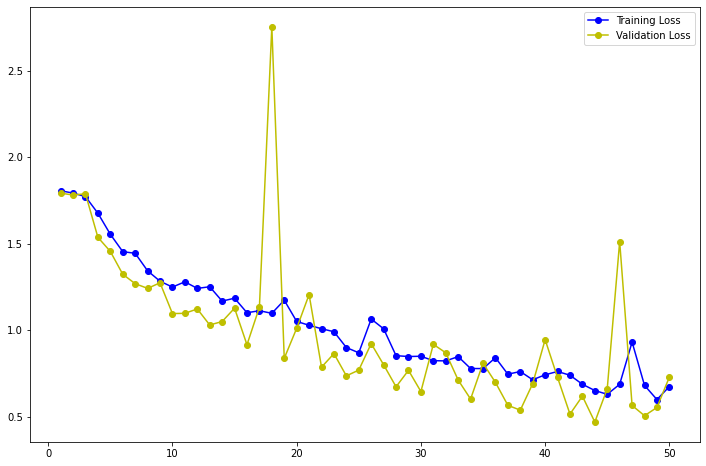

In [20]:
plt.figure(figsize=(12, 8))
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
length = range(1, 51)
plt.plot(length, train_loss, 'bo-', label = 'Training Loss')
plt.plot(length, valid_loss, 'yo-', label = 'Validation Loss')
plt.legend()

There is not much difference between the training loss and validation loss, that means our model is no longer overfitting the training set